In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
train = pd.read_csv('hm_train.csv')
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [2]:
train['predicted_category'].unique()

array(['affection', 'exercise', 'bonding', 'leisure', 'achievement',
       'enjoy_the_moment', 'nature'], dtype=object)

In [3]:
from tensorflow.keras import metrics

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from tensorflow.keras.utils.np_utils import to_categorical

In [5]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

# Combining titles and descriptions into a single sentence
text_clean = train['cleaned_hm'].values
text_class = train['predicted_category'].values
data_for_lstms = []
for i in range(len(train)):
    temp_list = [text_clean[i], text_class[i]]
    data_for_lstms.append(' '.join(temp_list))

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21567 unique tokens.


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encode = LabelEncoder().fit(train['predicted_category'])
Y = label_encode.transform(train['predicted_category'])
Y = Y.reshape(-1,1)
# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Shape of data tensor: (60321, 50)


Shape of data tensor: (60321, 50)
Shape of label tensor: (60321, 7)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
Total params: 2,081,107
Trainable params: 2,081,107
Non-trainable params: 0
______

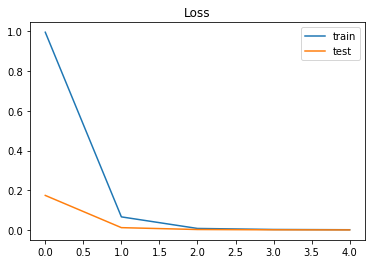

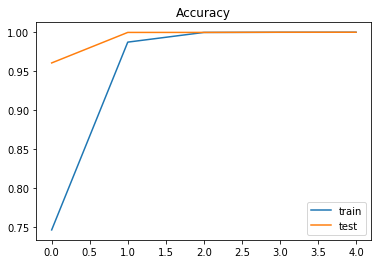

In [8]:

from sklearn.model_selection import train_test_split
# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Training LSTM Model
epochs = 5
batch_size = 500
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)
y_probas = model.predict(X_test)
y_pred = np.argmax(y_probas, axis=1)
y_test = np.argmax(Y_test, axis=1)

In [10]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=list(label_encode.classes_)))

                  precision    recall  f1-score   support

     achievement       1.00      1.00      1.00      5115
       affection       1.00      1.00      1.00      5196
         bonding       1.00      1.00      1.00      1652
enjoy_the_moment       1.00      1.00      1.00      1559
        exercise       1.00      1.00      1.00       189
         leisure       1.00      1.00      1.00      1084
          nature       1.00      1.00      1.00       286

        accuracy                           1.00     15081
       macro avg       1.00      1.00      1.00     15081
    weighted avg       1.00      1.00      1.00     15081



In [11]:
test = pd.read_csv('hm_test.csv')
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


In [12]:
X = tokenizer.texts_to_sequences(test['cleaned_hm'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
y_probas = model.predict(X)
y_pred = np.argmax(y_probas, axis=1)

In [14]:
len(y_pred)

40213

In [15]:
y_pred.shape

(40213,)

In [16]:
train['predicted_category'].shape

(60321,)

In [20]:
predicted_category = label_encode.inverse_transform(y_pred)
pd.Series(predicted_category).unique()

array(['affection', 'bonding', 'achievement', 'leisure', 'exercise',
       'enjoy_the_moment', 'nature'], dtype=object)

In [51]:
predicted_category

array(['affection', 'bonding', 'affection', ..., 'affection',
       'achievement', 'leisure'], dtype=object)

In [52]:
test['predicted_category']=predicted_category

In [53]:
test['cleaned_hm'][1]

'We moved back into our house after a remodel. We had lived in a hotel for 9 months due to our home being severely damaged in a tornado. '

In [60]:
my_dict = {'hmid':test['hmid'],'predicted_category':test['predicted_category']}

In [63]:
file = pd.DataFrame(my_dict,columns=['hmid','predicted_category'])
file.head()

,hmid,predicted_category
0,88305,affection
1,88306,bonding
2,88307,affection
3,88308,bonding
4,88309,affection


In [64]:
file.to_csv('hacker_earth_submission.csv',index=False,encoding="utf-8")

In [65]:
subb = pd.read_csv('hacker_earth_submission.csv')
subb.head()

,hmid,predicted_category
0,88305,affection
1,88306,bonding
2,88307,affection
3,88308,bonding
4,88309,affection
